# Business Case 5

## Data import and Preprocessing

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Fintech/Business Case 5/

Mounted at /gdrive
/gdrive/My Drive/Fintech/Business Case 5


In [2]:
!ls

NudgingContents.mat


In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

In [4]:
from scipy.io import loadmat

In [5]:
data_dict = loadmat('NudgingContents.mat')

personas = pd.DataFrame(data_dict['Personas'])
X_FR = pd.DataFrame(data_dict['X_FR'])
X_PC = pd.DataFrame(data_dict['X_PC'])
X_ST = pd.DataFrame(data_dict['X_ST'])
y_FR = pd.DataFrame(data_dict['y_FR'])
y_PC = pd.DataFrame(data_dict['y_PC'])
y_ST = pd.DataFrame(data_dict['y_ST'])

X_FR.columns = ['persona', 'age', 'gender', 'education']
X_PC.columns = ['persona', 'age', 'gender', 'education']
X_ST.columns = ['persona', 'age', 'gender', 'education']

y_FR.columns = ['response']
y_PC.columns = ['response']
y_ST.columns = ['response']

n_obs_FR = X_FR.shape[0]
n_obs_PC = X_PC.shape[0]
n_obs_ST = X_ST.shape[0]

In [6]:
personas.shape,X_FR.shape,X_PC.shape,X_ST.shape,y_FR.shape,y_PC.shape,y_ST.shape

((8, 3),
 (41233, 4),
 (41231, 4),
 (41633, 4),
 (41233, 1),
 (41231, 1),
 (41633, 1))

## Beta Distributions (Bayes approach)

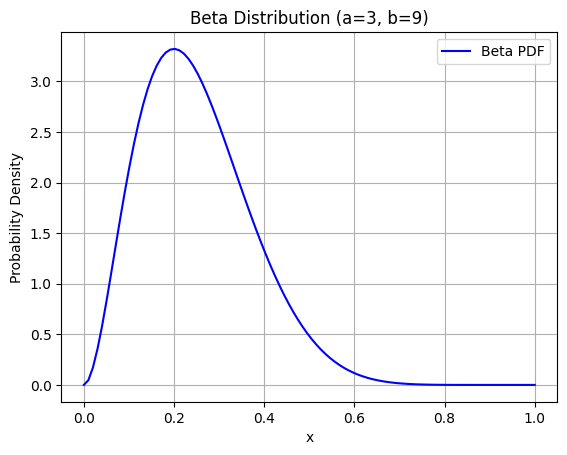

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Define the shape parameters
a = 3
b = 9

# Create an array of x values
x = np.linspace(0, 1, 100)  # Values between 0 and 1

# Calculate the PDF for each x value
pdf_values = beta.pdf(x, a, b)

# Plot the beta distribution
plt.plot(x, pdf_values, label='Beta PDF', color='blue')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Beta Distribution (a=3, b=9)')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
np.unique(X_ST['persona'].values)

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8)

NB INDEXES START FROM 1 AND GO TO 8

Persona 1

In [ ]:
# Initial Values
chunk = 50
aBetaPosterior = 0.0
bBetaPosterior = 0.0
meanProb = 0.0
modeProb = 0.0

i = 1

y = y_ST[X_ST['persona'] == i]  # responses for a given marketing persona
n = len(y)
nChunk = n // chunk
print(f'There are {n} positive points for storytelling with persona {i}')
print(f'With a chuck size of {chunk} we have {nChunk} chunks')

There are 3203 positive points for storytelling with persona 1
With a chuck size of 50 we have 64 chunks


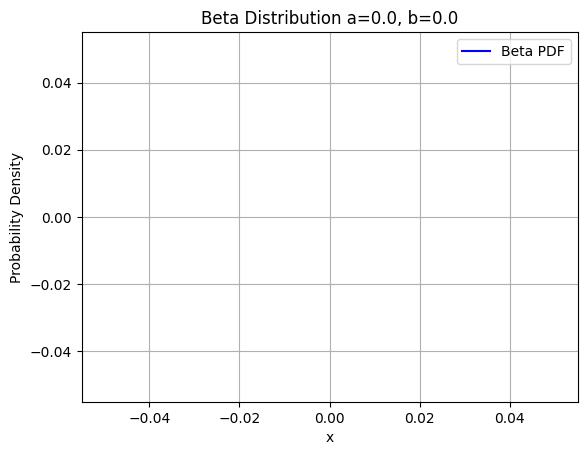

In [ ]:
# Create an array of x values
x = np.linspace(0, 1, 100)  # Values between 0 and 1

# Calculate the PDF for each x value
pdf_values = beta.pdf(x, aBetaPosterior, bBetaPosterior)

# Plot the beta distribution
plt.plot(x, pdf_values, label='Beta PDF', color='blue')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title(f'Beta Distribution a={aBetaPosterior}, b={bBetaPosterior}')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Priors & preallocation
aBetaPrior = 1.0
bBetaPrior = 1.0
aBetaPosterior_j = np.zeros(nChunk)  # store pdf parameter "a"
bBetaPosterior_j = np.zeros(nChunk)  # store pdf parameter "b"
meanProb_j = np.zeros(nChunk)  # store running mean
modeProb_j = np.zeros(nChunk)  # store running mode

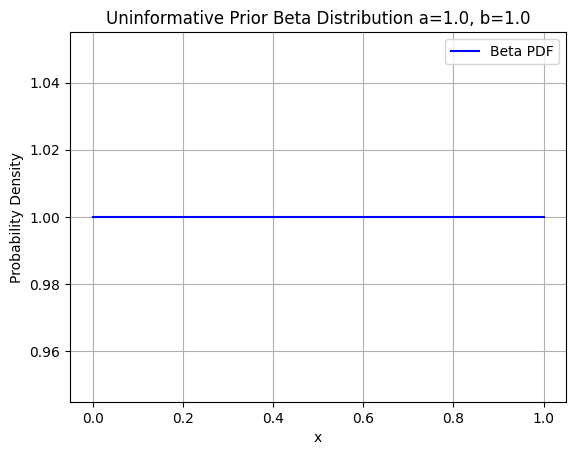

In [ ]:
# Create an array of x values
x = np.linspace(0, 1, 100)  # Values between 0 and 1

# Calculate the PDF for each x value
pdf_values = beta.pdf(x, aBetaPrior, bBetaPrior)

# Plot the beta distribution
plt.plot(x, pdf_values, label='Beta PDF', color='blue')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title(f'Uninformative Prior Beta Distribution a={aBetaPrior}, b={bBetaPrior}')
plt.grid(True)
plt.legend()
plt.show()

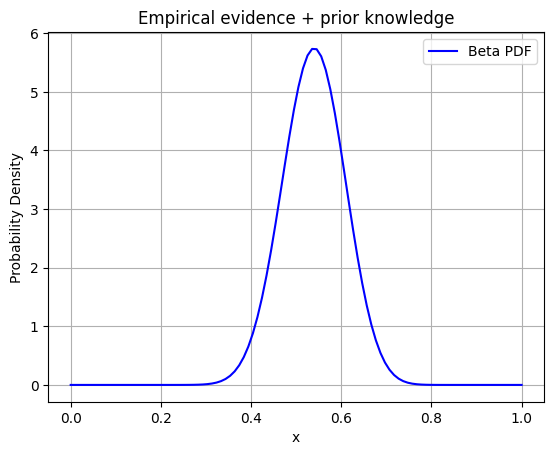

In [ ]:
# Simulate the arriving of the first chunk of data points
aLikelihood = len(y.values[0:chunk][y.values[0:chunk] > 0]) # number of users that clicked
bLikelihood = len(y.values[0:chunk][y.values[0:chunk] == 0]) #number of users that did not click

aPosterior = aLikelihood + aBetaPrior
bPosterior = bLikelihood + bBetaPrior

x = np.linspace(0, 1, 100)
pdf_values = beta.pdf(x, aPosterior, bPosterior)

# Plot the beta distribution
plt.plot(x, pdf_values, label='Beta PDF', color='blue')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title(f'Empirical evidence + prior knowledge')
plt.grid(True)
plt.legend()
plt.show()

Now we calculate final beta distribution for persona 1 with all datapoints altogether, then we will simulate online learning.

Number of users that clicked: 2057
Number of users that didn't click: 1146


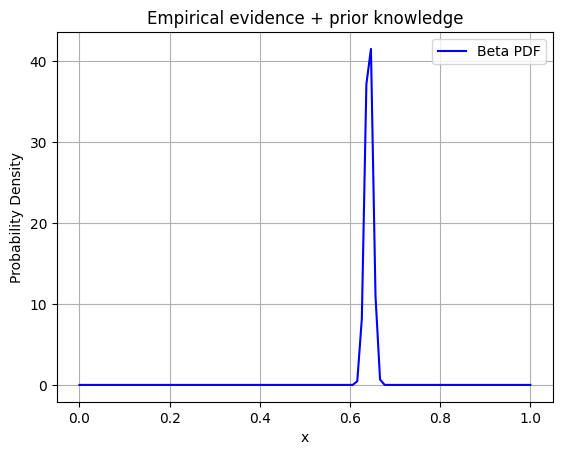

In [ ]:
# Simulate the arriving of the first chunk of data points
aLikelihood = len(y.values[y.values > 0]) # number of users that clicked
bLikelihood = len(y.values[y.values == 0]) #number of users that did not click

print(f"Number of users that clicked: {aLikelihood}")
print(f"Number of users that didn't click: {bLikelihood}")

aPosterior = aLikelihood + aBetaPrior
bPosterior = bLikelihood + bBetaPrior

x = np.linspace(0, 1, 100)
pdf_values = beta.pdf(x, aPosterior, bPosterior)

# Plot the beta distribution
plt.plot(x, pdf_values, label='Beta PDF', color='blue')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title(f'Empirical evidence + prior knowledge')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Incremental learning
for j in range(nChunk):
  ibegin = min(n, nChunk * (j - 1) + 1)
  iend = min(n, nChunk * j)
  nTot = len(y[ibegin:iend].values)  # chunk-sample size
  nClick = np.sum(y[ibegin:iend].values)  # number of positive responses

  #print(f"Number of users that clicked: {nClick}")
  #print(f"Number of users that didn't click: {nTot - nClick}")
  aBetaPosterior_j[j] = aBetaPrior + nClick  # parameter #1 update
  bBetaPosterior_j[j] = bBetaPrior + (nTot - nClick)  # parameter #2 update
  meanProb_j[j] = aBetaPosterior_j[j] / (aBetaPosterior_j[j] + bBetaPosterior_j[j])  # posterior mean
  modeProb_j[j] = (aBetaPosterior_j[j] - 1) / (aBetaPosterior_j[j] + bBetaPosterior_j[j] - 2)  # posterior mode
  aBetaPrior = aBetaPosterior_j[j]  # "Yesterday's posterior is today's prior"
  bBetaPrior = bBetaPosterior_j[j]  # "Yesterday's posterior is today's prior"

aBetaPosterior = aBetaPosterior_j
bBetaPosterior = bBetaPosterior_j
meanProb = meanProb_j
modeProb = modeProb_j

<ipython-input-15-d1601c90a642>:13: RuntimeWarning: invalid value encountered in scalar divide
  modeProb_j[j] = (aBetaPosterior_j[j] - 1) / (aBetaPosterior_j[j] + bBetaPosterior_j[j] - 2)  # posterior mode


In [ ]:
nChunk*chunk

3200

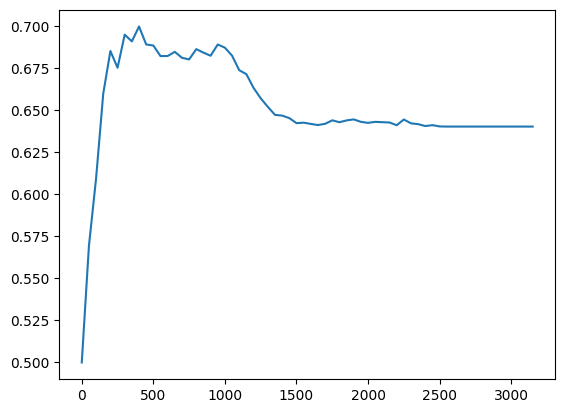

In [ ]:
# Plot convergence of mean to a fixed value
x = [n*50 for n in range(0,nChunk)]
plt.plot(x,meanProb)

In [ ]:
# final probability of clicking
meanProb[-1]

0.640139505389981

All personas, storytelling

In [ ]:
chunk = 50
num_personas = personas.shape[0]
aBetaPosterior = [0.0] * num_personas
bBetaPosterior = [0.0] * num_personas
meanProb = [0.0] * num_personas
modeProb = [0.0] * num_personas

nchunks = []

for i in range(1, num_personas+1):
    y = y_ST[X_ST['persona'] == i]  # responses for a given marketing persona
    n = len(y)
    nChunk = n // chunk
    nchunks.append(nChunk)

    # Priors & preallocation
    aBetaPrior = 1.0
    bBetaPrior = 1.0
    aBetaPosterior_j = np.zeros(nChunk)  # store pdf parameter "a"
    bBetaPosterior_j = np.zeros(nChunk)  # store pdf parameter "b"
    meanProb_j = np.zeros(nChunk)  # store running mean
    modeProb_j = np.zeros(nChunk)  # store running mode

    # Incremental learning
    for j in range(nChunk):
        ibegin = min(n, nChunk * (j - 1) + 1)
        iend = min(n, nChunk * j)
        #print(f'\ni begin, i end {ibegin},{iend}')
        # fit and update metrics
        nTot = len(y[ibegin:iend].values)  # chunk-sample size
        nClick = np.sum(y[ibegin:iend].values)  # number of positive responses
        #print(f'\nntot, nclick, {nTot},{nClick}')
        aBetaPosterior_j[j] = aBetaPrior + nClick  # parameter #1 update
        bBetaPosterior_j[j] = bBetaPrior + (nTot - nClick)  # parameter #2 update
        #print(f'\nabpost, bbpost, {aBetaPosterior_j[j]}, {bBetaPosterior_j[j]}')
        meanProb_j[j] = aBetaPosterior_j[j] / (aBetaPosterior_j[j] + bBetaPosterior_j[j])  # posterior mean
        modeProb_j[j] = (aBetaPosterior_j[j] - 1) / (aBetaPosterior_j[j] + bBetaPosterior_j[j] - 2)  # posterior mode
        aBetaPrior = aBetaPosterior_j[j]  # "Yesterday's posterior is today's prior"
        bBetaPrior = bBetaPosterior_j[j]  # "Yesterday's posterior is today's prior"

    aBetaPosterior[i-1] = aBetaPosterior_j
    bBetaPosterior[i-1] = bBetaPosterior_j
    meanProb[i-1] = meanProb_j
    modeProb[i-1] = modeProb_j

<ipython-input-19-d416e333c0ab>:37: RuntimeWarning: invalid value encountered in scalar divide
  modeProb_j[j] = (aBetaPosterior_j[j] - 1) / (aBetaPosterior_j[j] + bBetaPosterior_j[j] - 2)  # posterior mode


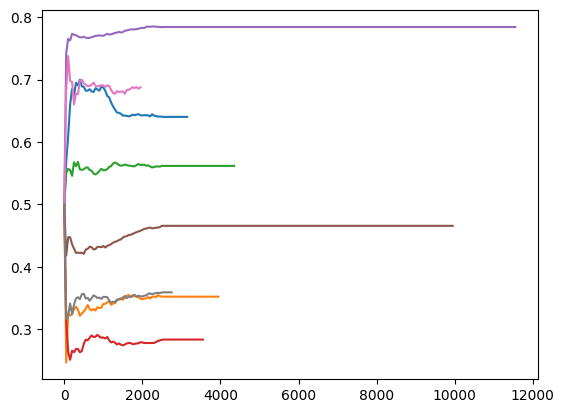

In [ ]:
for i in range(1, num_personas+1):
  x = [n*50 for n in range(0,nchunks[i-1])]
  plt.plot(x,meanProb[i-1])

In [ ]:
# Store the last, updated values
ST_LastProb = np.zeros(num_personas)
for i in range(1, num_personas+1):
  ST_LastProb[i-1] = meanProb[i-1][-1]

In [ ]:
ST_LastProb

array([0.64013951, 0.35230147, 0.56165327, 0.28362409, 0.78406437,
       0.46570941, 0.68745896, 0.35924446])

Now we define a function that performs this analysis and perform the analysis on all methods, ST, etc.

In [ ]:
def analyze(X_tgt, y_tgt):
  chunk = 50
  num_personas = personas.shape[0]
  aBetaPosterior = [0.0] * num_personas
  bBetaPosterior = [0.0] * num_personas
  meanProb = [0.0] * num_personas
  modeProb = [0.0] * num_personas

  nchunks = []

  for i in range(1, num_personas+1):
      y = y_tgt[X_tgt['persona'] == i]  # responses for a given marketing persona
      n = len(y)
      nChunk = n // chunk
      nchunks.append(nChunk)

      # Priors & preallocation
      aBetaPrior = 1.0
      bBetaPrior = 1.0
      aBetaPosterior_j = np.zeros(nChunk)  # store pdf parameter "a"
      bBetaPosterior_j = np.zeros(nChunk)  # store pdf parameter "b"
      meanProb_j = np.zeros(nChunk)  # store running mean
      modeProb_j = np.zeros(nChunk)  # store running mode

      # Incremental learning
      for j in range(nChunk):
          ibegin = min(n, nChunk * (j - 1) + 1)
          iend = min(n, nChunk * j)
          #print(f'\ni begin, i end {ibegin},{iend}')
          # fit and update metrics
          nTot = len(y[ibegin:iend].values)  # chunk-sample size
          nClick = np.sum(y[ibegin:iend].values)  # number of positive responses
          #print(f'\nntot, nclick, {nTot},{nClick}')
          aBetaPosterior_j[j] = aBetaPrior + nClick  # parameter #1 update
          bBetaPosterior_j[j] = bBetaPrior + (nTot - nClick)  # parameter #2 update
          #print(f'\nabpost, bbpost, {aBetaPosterior_j[j]}, {bBetaPosterior_j[j]}')
          meanProb_j[j] = aBetaPosterior_j[j] / (aBetaPosterior_j[j] + bBetaPosterior_j[j])  # posterior mean
          modeProb_j[j] = (aBetaPosterior_j[j] - 1) / (aBetaPosterior_j[j] + bBetaPosterior_j[j] - 2)  # posterior mode
          aBetaPrior = aBetaPosterior_j[j]  # "Yesterday's posterior is today's prior"
          bBetaPrior = bBetaPosterior_j[j]  # "Yesterday's posterior is today's prior"

      aBetaPosterior[i-1] = aBetaPosterior_j
      bBetaPosterior[i-1] = bBetaPosterior_j
      meanProb[i-1] = meanProb_j
      modeProb[i-1] = modeProb_j

  for i in range(1, num_personas+1):
    x = [n*50 for n in range(0,nchunks[i-1])]
    plt.plot(x,meanProb[i-1])

  # Store the last, updated values
  lastProb = np.zeros(num_personas)
  for i in range(1, num_personas+1):
    lastProb[i-1] = meanProb[i-1][-1]

  return lastProb, meanProb

<ipython-input-23-aba61e0f4c3e>:38: RuntimeWarning: invalid value encountered in scalar divide
  modeProb_j[j] = (aBetaPosterior_j[j] - 1) / (aBetaPosterior_j[j] + bBetaPosterior_j[j] - 2)  # posterior mode


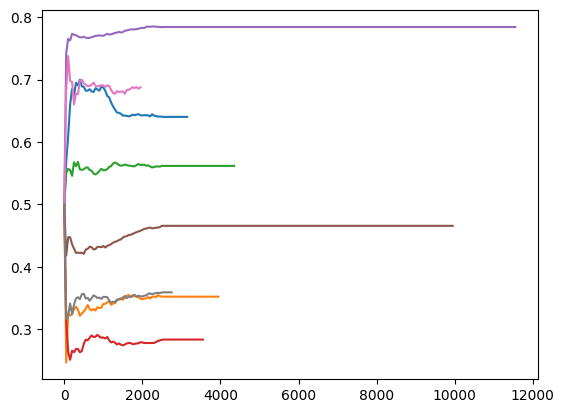

In [ ]:
last_ST, mean_prob_ST = analyze(X_ST, y_ST)

<ipython-input-23-aba61e0f4c3e>:38: RuntimeWarning: invalid value encountered in scalar divide
  modeProb_j[j] = (aBetaPosterior_j[j] - 1) / (aBetaPosterior_j[j] + bBetaPosterior_j[j] - 2)  # posterior mode


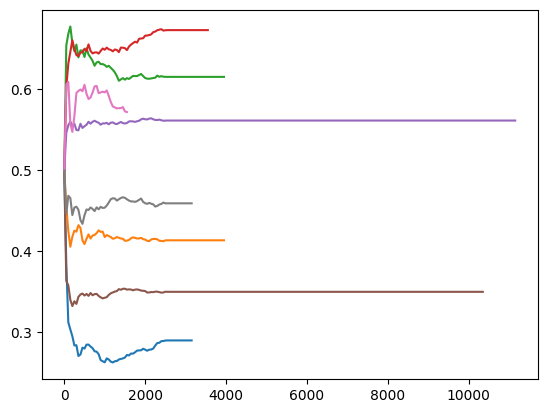

In [ ]:
last_FR, mean_prob_FR = analyze(X_FR, y_FR)

<ipython-input-23-aba61e0f4c3e>:38: RuntimeWarning: invalid value encountered in scalar divide
  modeProb_j[j] = (aBetaPosterior_j[j] - 1) / (aBetaPosterior_j[j] + bBetaPosterior_j[j] - 2)  # posterior mode


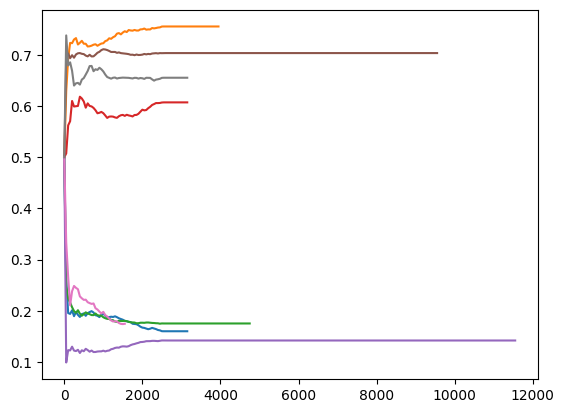

In [ ]:
last_PC, mean_prob_PC = analyze(X_PC, y_PC)

In [ ]:
personas = [int(i) for i in range(1,9)]
summary = np.array([personas, last_FR, last_PC, last_ST]).transpose()
summary = pd.DataFrame(summary, columns=['Persona', 'Framing', 'Peer Comparison', 'Storytelling'])
summary

,Persona,Framing,Peer Comparison,Storytelling
0,1.0,0.290108,0.159797,0.640140
1,2.0,0.413758,0.755943,0.352301
2,3.0,0.615579,0.175011,0.561653
3,4.0,0.673326,0.607483,0.283624
4,5.0,0.561649,0.141708,0.784064
5,6.0,0.350130,0.703913,0.465709
6,7.0,0.572170,0.174455,0.687459
7,8.0,0.459417,0.655675,0.359244


In [ ]:
personas = pd.DataFrame(data_dict['Personas'])
personas

,0,1,2
0,0,0,0
1,0,1,0
2,0,0,1
3,0,1,1
4,1,0,0
5,1,1,0
6,1,0,1
7,1,1,1


In [ ]:
# When a new user arrives
tactics = summary.columns[1:4]

new_user = [0,0,1] #persona number 001
corresponding_persona = new_user[0]*4 + new_user[1] + new_user[2]*2
response = summary.iloc[corresponding_persona].values

print(f'New user has been classified to persona {response[0]}')
print(f'Value for Framing: {response[1]}')
print(f'Value for Peer Comparison: {response[2]}')
print(f'Value for Storytelling: {response[3]}')

suggested_tactic_index = np.where(response == np.max(response[1:4]))[0][0]
sugg_tac = tactics[suggested_tactic_index]
print('Suggested tactic is: ' + sugg_tac)

New user has been classified to persona 3.0
Value for Framing: 0.6155791603439554
Value for Peer Comparison: 0.1750105174589819
Value for Storytelling: 0.5616532721010333
Suggested tactic is: Peer Comparison


## Logistic Regression

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


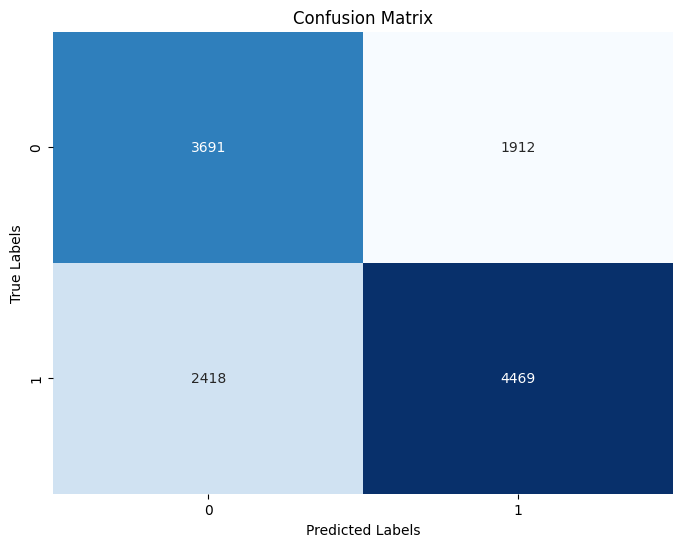

Accuracy: 0.65
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.66      0.63      5603
           1       0.70      0.65      0.67      6887

    accuracy                           0.65     12490
   macro avg       0.65      0.65      0.65     12490
weighted avg       0.66      0.65      0.65     12490



In [ ]:
# Assuming X_ST and y_ST are your feature matrix and target variable
X = X_ST
y = y_ST

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report_str)

In [ ]:
def evaluate_Log_Reg(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.3, random_state=42)
  clf = LogisticRegression()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  classification_report_str = classification_report(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.show()

  print(f"Accuracy: {accuracy:.2f}")
  print("Classification Report:\n", classification_report_str)

  return clf

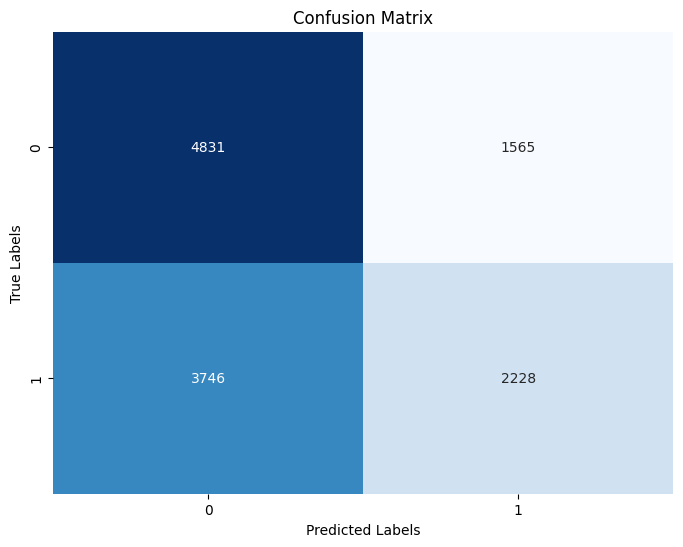

Accuracy: 0.57
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.76      0.65      6396
           1       0.59      0.37      0.46      5974

    accuracy                           0.57     12370
   macro avg       0.58      0.56      0.55     12370
weighted avg       0.57      0.57      0.55     12370



In [ ]:
log_FR = evaluate_Log_Reg(X_FR, y_FR)

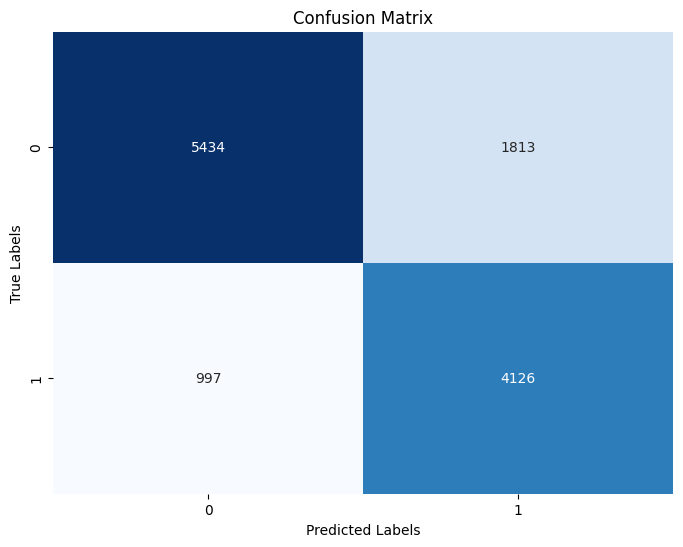

Accuracy: 0.77
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.75      0.79      7247
           1       0.69      0.81      0.75      5123

    accuracy                           0.77     12370
   macro avg       0.77      0.78      0.77     12370
weighted avg       0.78      0.77      0.77     12370



In [ ]:
log_PC = evaluate_Log_Reg(X_PC, y_PC)

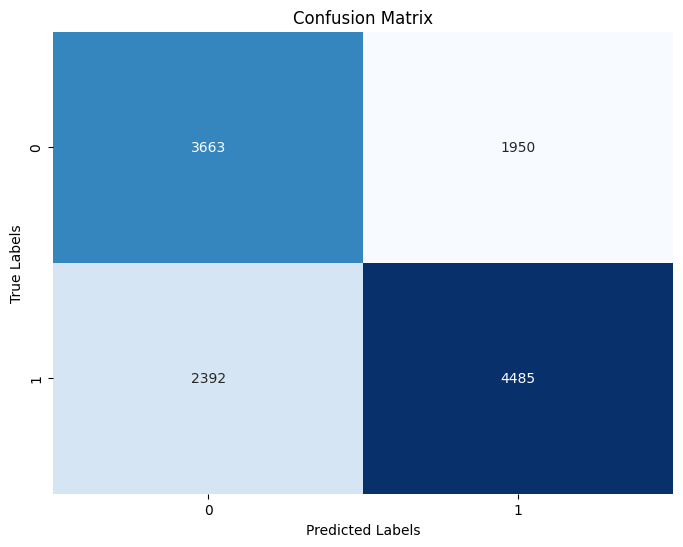

Accuracy: 0.65
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.65      0.63      5613
           1       0.70      0.65      0.67      6877

    accuracy                           0.65     12490
   macro avg       0.65      0.65      0.65     12490
weighted avg       0.66      0.65      0.65     12490



In [ ]:
log_ST = evaluate_Log_Reg(X_ST, y_ST)

In [ ]:
# new user arrives
new_user = [0,0,1] #persona number 001
corresponding_persona = new_user[0]*4 + new_user[1] + new_user[2]*2


new_user = pd.DataFrame(np.array([corresponding_persona,0,0,1]).reshape(1, -1))
new_user.columns = ['persona', 'age', 'gender', 'education']

prediction_FR = log_FR.predict(new_user)
prediction_PC = log_PC.predict(new_user)
prediction_ST = log_ST.predict(new_user)
response = [corresponding_persona, prediction_FR[0], prediction_PC[0], prediction_ST[0]]

# When a new user arrives
tactics = ['Framing', 'Peer Comparison', 'Storytelling']

print(f'New user has been classified to persona {response[0]}')
print(f'Value for Framing: {response[1]}')
print(f'Value for Peer Comparison: {response[2]}')
print(f'Value for Storytelling: {response[3]}')

suggested_tactic_index = np.where(response == np.max(response[1:4]))[0]

for i in suggested_tactic_index:
  sugg_tac = tactics[i-1]
  print('Suggested tactic is: ' + sugg_tac)

New user has been classified to persona 2
Value for Framing: 1
Value for Peer Comparison: 0
Value for Storytelling: 1
Suggested tactic is: Framing
Suggested tactic is: Storytelling


## SVM Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ST, y_ST.values.ravel(), test_size=0.33, random_state=42)

# Initialize the SVM classifier
clf = SVC(kernel='rbf')  # You can choose different kernels (e.g., 'rbf', 'poly', etc.)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

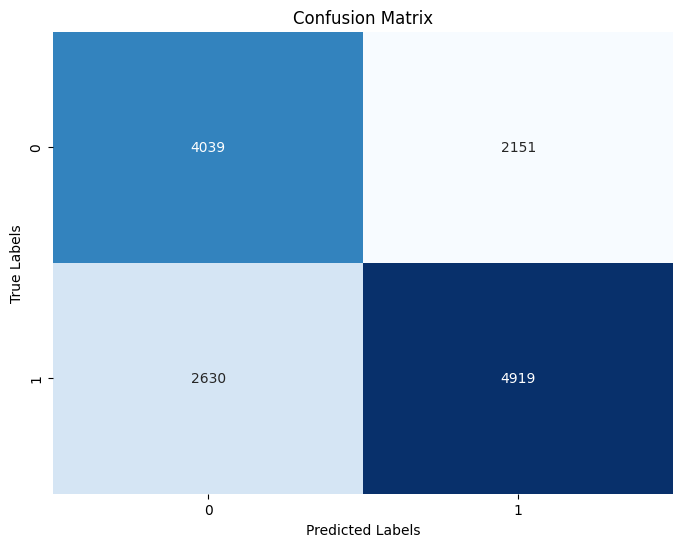


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      6190
           1       0.70      0.65      0.67      7549

    accuracy                           0.65     13739
   macro avg       0.65      0.65      0.65     13739
weighted avg       0.66      0.65      0.65     13739



In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Additional metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
svm_kernels = [
    "linear",
    "poly",
    "rbf",
    "sigmoid"
]

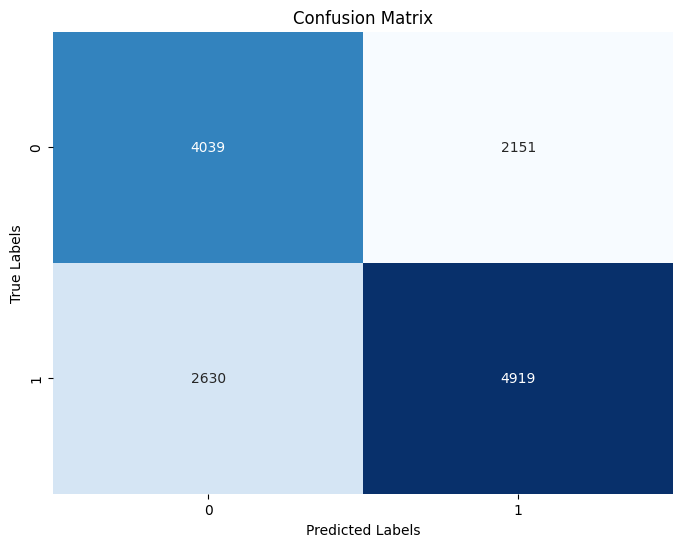


Classification Report for linear kernel:
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      6190
           1       0.70      0.65      0.67      7549

    accuracy                           0.65     13739
   macro avg       0.65      0.65      0.65     13739
weighted avg       0.66      0.65      0.65     13739



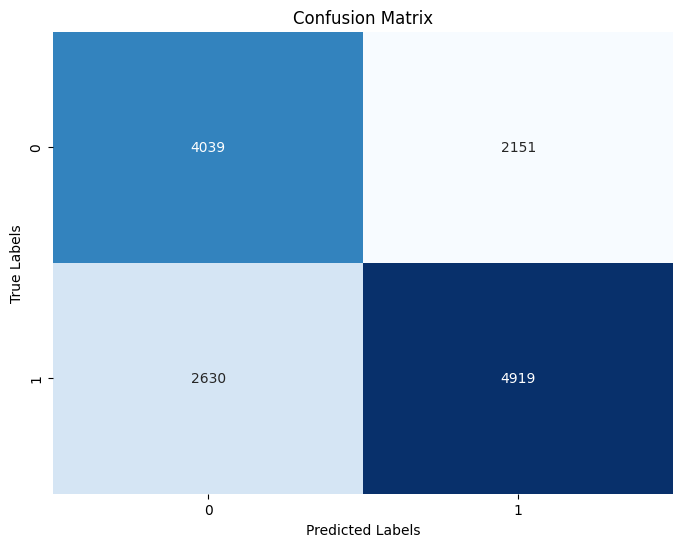


Classification Report for poly kernel:
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      6190
           1       0.70      0.65      0.67      7549

    accuracy                           0.65     13739
   macro avg       0.65      0.65      0.65     13739
weighted avg       0.66      0.65      0.65     13739



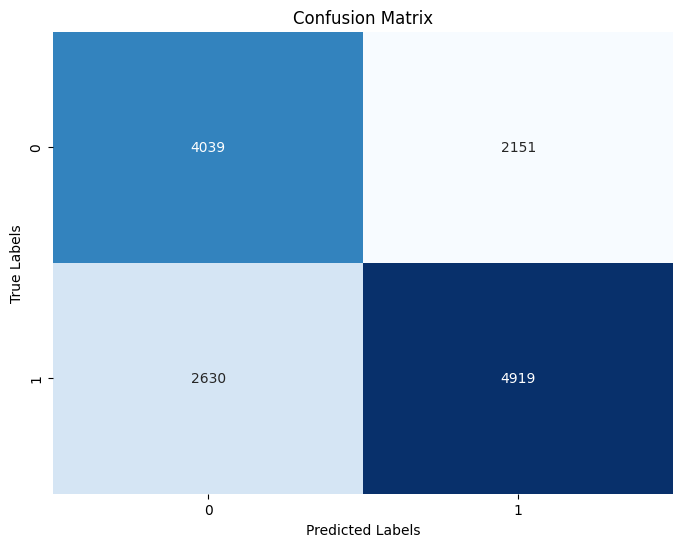


Classification Report for rbf kernel:
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      6190
           1       0.70      0.65      0.67      7549

    accuracy                           0.65     13739
   macro avg       0.65      0.65      0.65     13739
weighted avg       0.66      0.65      0.65     13739



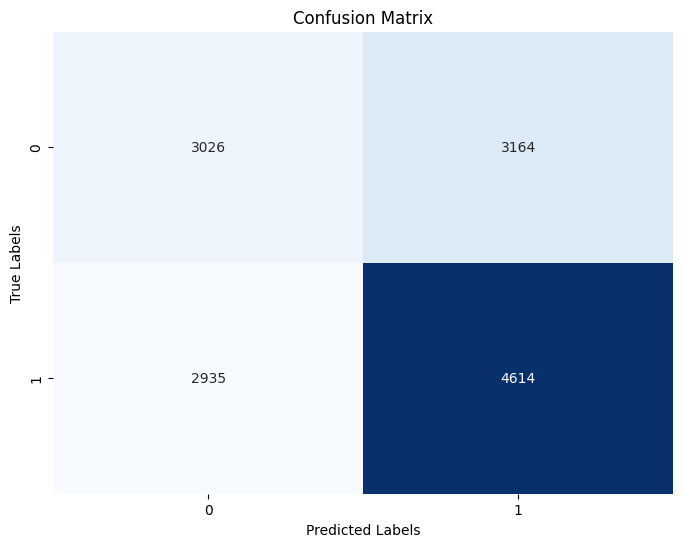


Classification Report for sigmoid kernel:
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      6190
           1       0.59      0.61      0.60      7549

    accuracy                           0.56     13739
   macro avg       0.55      0.55      0.55     13739
weighted avg       0.55      0.56      0.56     13739



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ST, y_ST.values.ravel(), test_size=0.33, random_state=42)

for kernel in svm_kernels:
  clf = SVC(kernel=kernel)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  conf_matrix = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.show()

  # Additional metrics
  print(f"\nClassification Report for {kernel} kernel:")
  print(classification_report(y_test, y_pred))

For SVM classifier the best performing kernels seem to be: linear, poly, rbf. Sigmoid kernel gives poor results, precomputed kernel can't be used since matrix is not square. For the sake of simplicity we are choosing linear kernel from now on (for SVC).

In [ ]:
def evaluate_SVC(X_train, X_test, y_train, y_test, kernel='linear'):
  clf = SVC(kernel=kernel)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  conf_matrix = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.show()
  print(f"\nClassification Report for {kernel} kernel:")
  print(classification_report(y_test, y_pred))

  return clf

In [ ]:
X_train_FR, X_test_FR, y_train_FR, y_test_FR = train_test_split(X_FR, y_FR.values.ravel(), test_size=0.33, random_state=42)
X_train_PC, X_test_PC, y_train_PC, y_test_PC = train_test_split(X_PC, y_PC.values.ravel(), test_size=0.33, random_state=42)
X_train_ST, X_test_ST, y_train_ST, y_test_ST = train_test_split(X_ST, y_ST.values.ravel(), test_size=0.33, random_state=42)

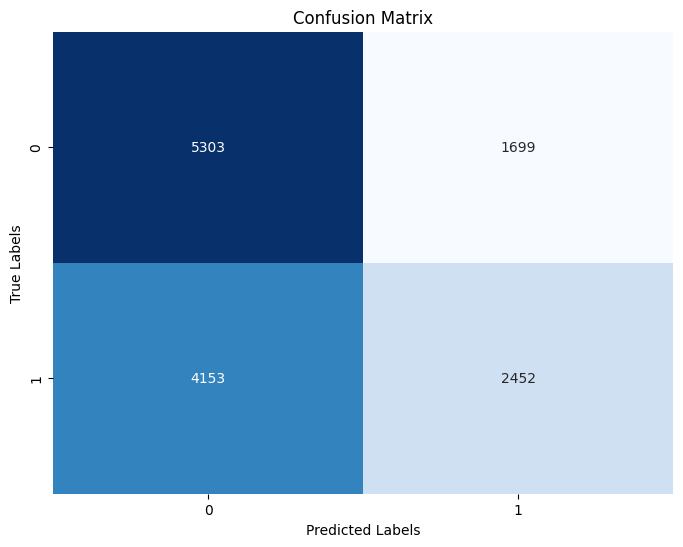


Classification Report for linear kernel:
              precision    recall  f1-score   support

           0       0.56      0.76      0.64      7002
           1       0.59      0.37      0.46      6605

    accuracy                           0.57     13607
   macro avg       0.58      0.56      0.55     13607
weighted avg       0.58      0.57      0.55     13607



In [ ]:
svc_FR = evaluate_SVC(X_train_FR, X_test_FR, y_train_FR, y_test_FR, kernel='linear')

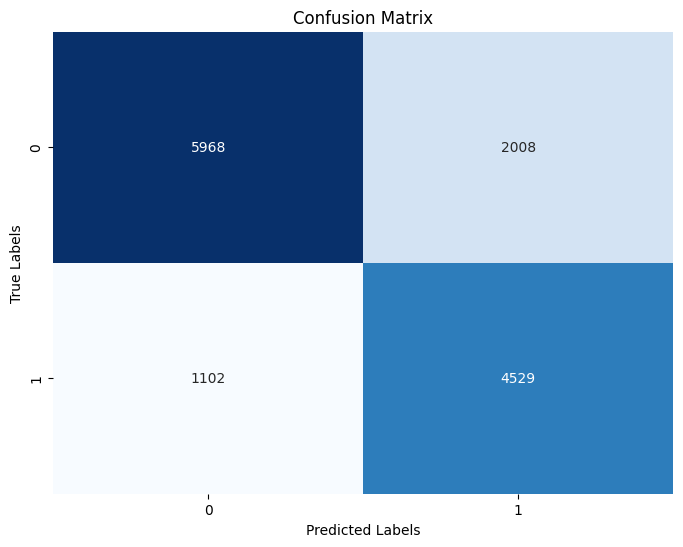


Classification Report for linear kernel:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79      7976
           1       0.69      0.80      0.74      5631

    accuracy                           0.77     13607
   macro avg       0.77      0.78      0.77     13607
weighted avg       0.78      0.77      0.77     13607



In [ ]:
svc_PC = evaluate_SVC(X_train_PC, X_test_PC, y_train_PC, y_test_PC, kernel='linear')

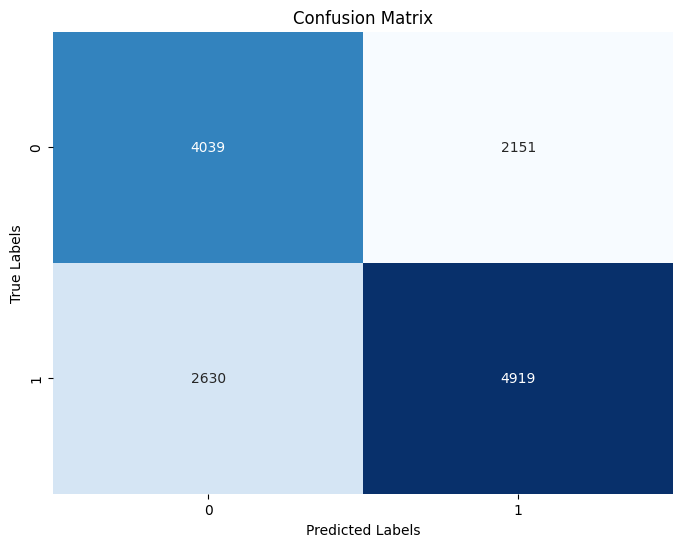


Classification Report for linear kernel:
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      6190
           1       0.70      0.65      0.67      7549

    accuracy                           0.65     13739
   macro avg       0.65      0.65      0.65     13739
weighted avg       0.66      0.65      0.65     13739



In [ ]:
svc_ST = evaluate_SVC(X_train_ST, X_test_ST, y_train_ST, y_test_ST, kernel='linear')

In [ ]:
# new user arrives
new_user = [0,0,1] #persona number 001
corresponding_persona = new_user[0]*4 + new_user[1] + new_user[2]*2


new_user = pd.DataFrame(np.array([corresponding_persona,0,0,1]).reshape(1, -1))
new_user.columns = ['persona', 'age', 'gender', 'education']

prediction_FR = svc_FR.predict(new_user)
prediction_PC = svc_PC.predict(new_user)
prediction_ST = svc_ST.predict(new_user)
response = [corresponding_persona, prediction_FR[0], prediction_PC[0], prediction_ST[0]]

# When a new user arrives
tactics = ['Framing', 'Peer Comparison', 'Storytelling']

print(f'New user has been classified to persona {response[0]}')
print(f'Value for Framing: {response[1]}')
print(f'Value for Peer Comparison: {response[2]}')
print(f'Value for Storytelling: {response[3]}')

suggested_tactic_index = np.where(response == np.max(response[1:4]))[0]

for i in suggested_tactic_index:
  sugg_tac = tactics[i-1]
  print('Suggested tactic is: ' + sugg_tac)

New user has been classified to persona 2
Value for Framing: 1
Value for Peer Comparison: 0
Value for Storytelling: 1
Suggested tactic is: Framing
Suggested tactic is: Storytelling


## Decistion Trees

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

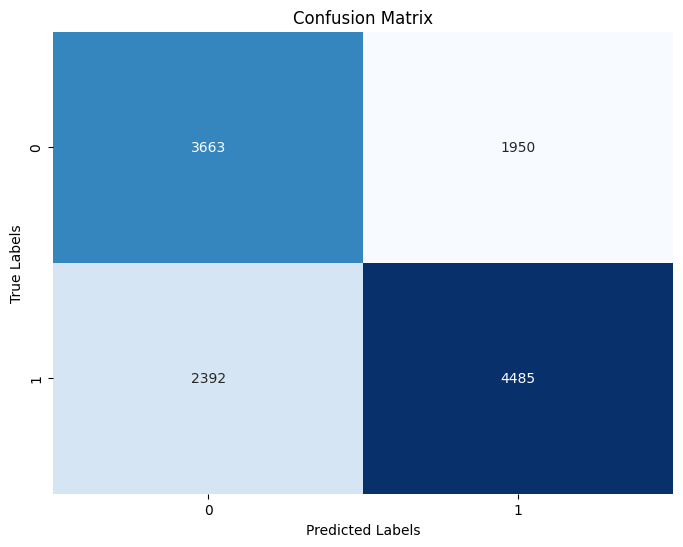

Accuracy: 0.65
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.65      0.63      5613
           1       0.70      0.65      0.67      6877

    accuracy                           0.65     12490
   macro avg       0.65      0.65      0.65     12490
weighted avg       0.66      0.65      0.65     12490



In [ ]:
# Assuming X_ST and y_ST are your feature matrix and target variable
X = X_ST
y = y_ST

# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=0)

# Fit the model to the training data
tree.fit(X_train, y_train)

# Make predictions on the test set
y_pred = tree.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report_str)

In [ ]:
def evaluate_tree(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
  tree = DecisionTreeClassifier(random_state=0)
  tree.fit(X_train, y_train)
  y_pred = tree.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  classification_report_str = classification_report(y_test, y_pred)

  conf_matrix = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.show()

  print(f"Accuracy: {accuracy:.2f}")
  print("Classification Report:\n", classification_report_str)

  return tree

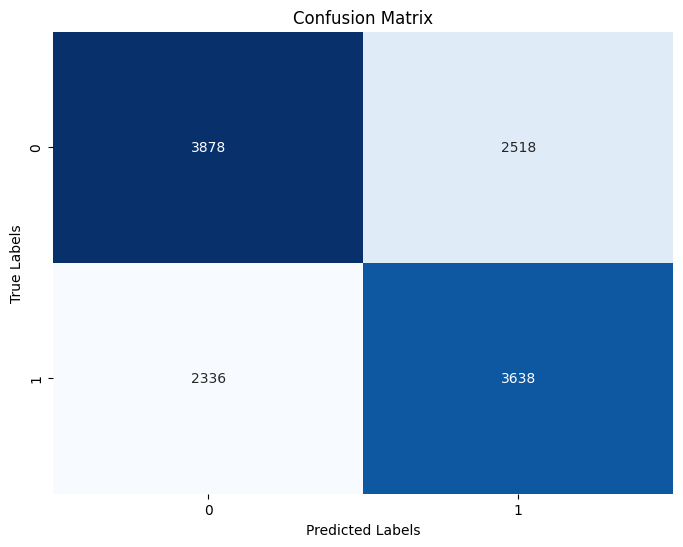

Accuracy: 0.61
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.61      0.62      6396
           1       0.59      0.61      0.60      5974

    accuracy                           0.61     12370
   macro avg       0.61      0.61      0.61     12370
weighted avg       0.61      0.61      0.61     12370



In [ ]:
tree_FR = evaluate_tree(X_FR, y_FR)

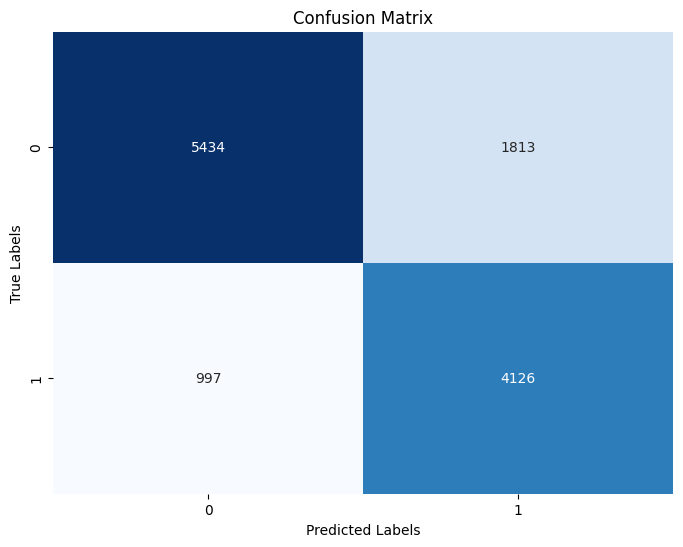

Accuracy: 0.77
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.75      0.79      7247
           1       0.69      0.81      0.75      5123

    accuracy                           0.77     12370
   macro avg       0.77      0.78      0.77     12370
weighted avg       0.78      0.77      0.77     12370



In [ ]:
tree_PC = evaluate_tree(X_PC, y_PC)

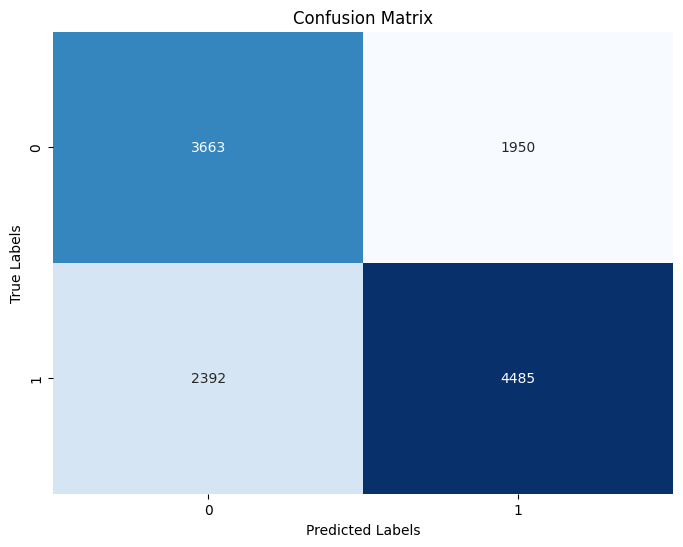

Accuracy: 0.65
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.65      0.63      5613
           1       0.70      0.65      0.67      6877

    accuracy                           0.65     12490
   macro avg       0.65      0.65      0.65     12490
weighted avg       0.66      0.65      0.65     12490



In [ ]:
tree_ST = evaluate_tree(X_ST, y_ST)

In [ ]:
# new user arrives
new_user = [0,0,1] #persona number 001
corresponding_persona = new_user[0]*4 + new_user[1] + new_user[2]*2

new_user = pd.DataFrame(np.array([corresponding_persona,0,0,1]).reshape(1, -1))
new_user.columns = ['persona', 'age', 'gender', 'education']

prediction_FR = tree_FR.predict(new_user)
prediction_PC = tree_PC.predict(new_user)
prediction_ST = tree_ST.predict(new_user)
response = [corresponding_persona, prediction_FR[0], prediction_PC[0], prediction_ST[0]]

# When a new user arrives
tactics = ['Framing', 'Peer Comparison', 'Storytelling']

print(f'New user has been classified to persona {response[0]}')
print(f'Value for Framing: {response[1]}')
print(f'Value for Peer Comparison: {response[2]}')
print(f'Value for Storytelling: {response[3]}')

suggested_tactic_index = np.where(response == np.max(response[1:4]))[0]

for i in suggested_tactic_index:
  sugg_tac = tactics[i-1]
  print('Suggested tactic is: ' + sugg_tac)

New user has been classified to persona 2
Value for Framing: 1
Value for Peer Comparison: 0
Value for Storytelling: 1
Suggested tactic is: Framing
Suggested tactic is: Storytelling


## Random Forest

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Assuming X_ST and y_ST are your feature matrix and target variable
X = X_ST
y = y_ST

# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Initialize the Random Forest Classifier
forest = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit the model to the training data
forest.fit(X_train, y_train)

# Make predictions on the test set
y_pred = forest.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report_str)


<ipython-input-116-c8f215e671ef>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


Accuracy: 0.65
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.66      0.63      5603
           1       0.70      0.65      0.67      6887

    accuracy                           0.65     12490
   macro avg       0.65      0.65      0.65     12490
weighted avg       0.66      0.65      0.65     12490



In [ ]:
def evaluate_forest(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.3, random_state=0)
  forest = RandomForestClassifier(n_estimators=100, random_state=0)
  forest.fit(X_train, y_train)
  y_pred = forest.predict(X_test)

  conf_matrix = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.show()

  accuracy = accuracy_score(y_test, y_pred)
  classification_report_str = classification_report(y_test, y_pred)

  print(f"Accuracy: {accuracy:.2f}")
  print("Classification Report:\n", classification_report_str)

  return forest

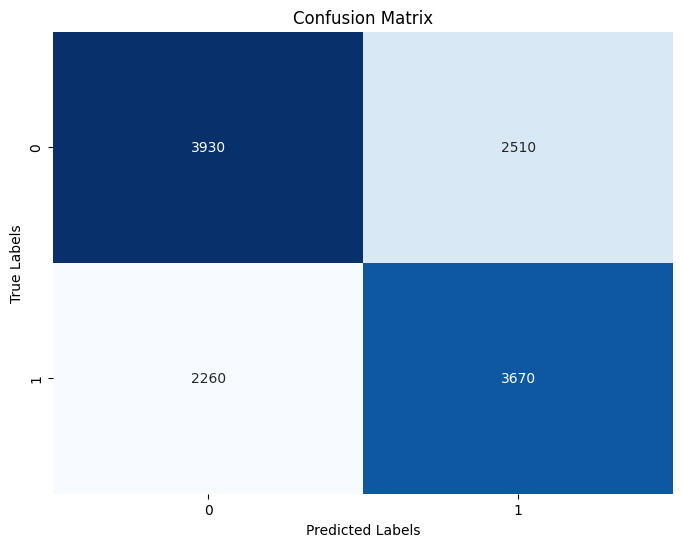

Accuracy: 0.61
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.61      0.62      6440
           1       0.59      0.62      0.61      5930

    accuracy                           0.61     12370
   macro avg       0.61      0.61      0.61     12370
weighted avg       0.62      0.61      0.61     12370



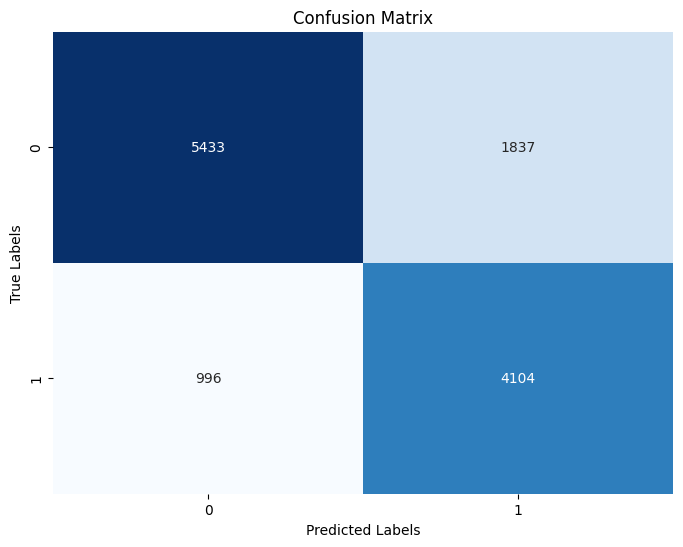

Accuracy: 0.77
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.75      0.79      7270
           1       0.69      0.80      0.74      5100

    accuracy                           0.77     12370
   macro avg       0.77      0.78      0.77     12370
weighted avg       0.78      0.77      0.77     12370



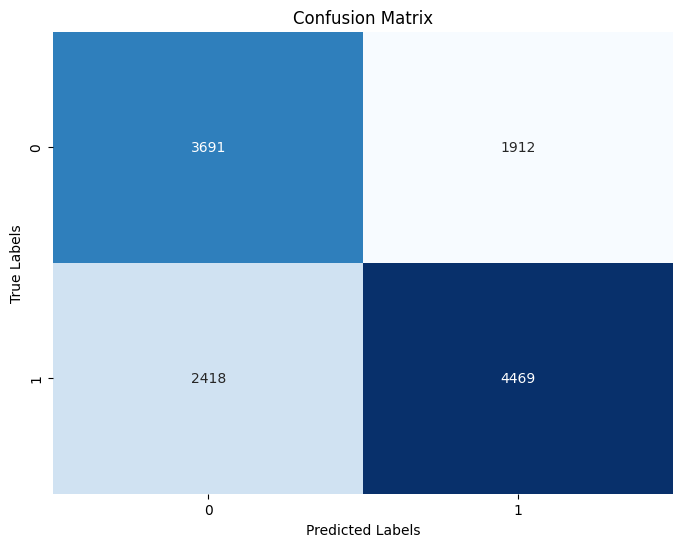

Accuracy: 0.65
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.66      0.63      5603
           1       0.70      0.65      0.67      6887

    accuracy                           0.65     12490
   macro avg       0.65      0.65      0.65     12490
weighted avg       0.66      0.65      0.65     12490



In [ ]:
forest_FR = evaluate_forest(X_FR, y_FR)
forest_PC = evaluate_forest(X_PC, y_PC)
forest_ST = evaluate_forest(X_ST, y_ST)

In [ ]:
# new user arrives
new_user = [0,0,1] #persona number 001
corresponding_persona = new_user[0]*4 + new_user[1] + new_user[2]*2

new_user = pd.DataFrame(np.array([corresponding_persona,0,0,1]).reshape(1, -1))
new_user.columns = ['persona', 'age', 'gender', 'education']

prediction_FR = forest_FR.predict(new_user)
prediction_PC = forest_PC.predict(new_user)
prediction_ST = forest_ST.predict(new_user)
response = [corresponding_persona, prediction_FR[0], prediction_PC[0], prediction_ST[0]]

# When a new user arrives
tactics = ['Framing', 'Peer Comparison', 'Storytelling']

print(f'New user has been classified to persona {response[0]}')
print(f'Value for Framing: {response[1]}')
print(f'Value for Peer Comparison: {response[2]}')
print(f'Value for Storytelling: {response[3]}')

suggested_tactic_index = np.where(response == np.max(response[1:4]))[0]

for i in suggested_tactic_index:
  sugg_tac = tactics[i-1]
  print('Suggested tactic is: ' + sugg_tac)

New user has been classified to persona 2
Value for Framing: 1
Value for Peer Comparison: 0
Value for Storytelling: 1
Suggested tactic is: Framing
Suggested tactic is: Storytelling


## Ensemble method

In [ ]:
from scipy.stats import mode

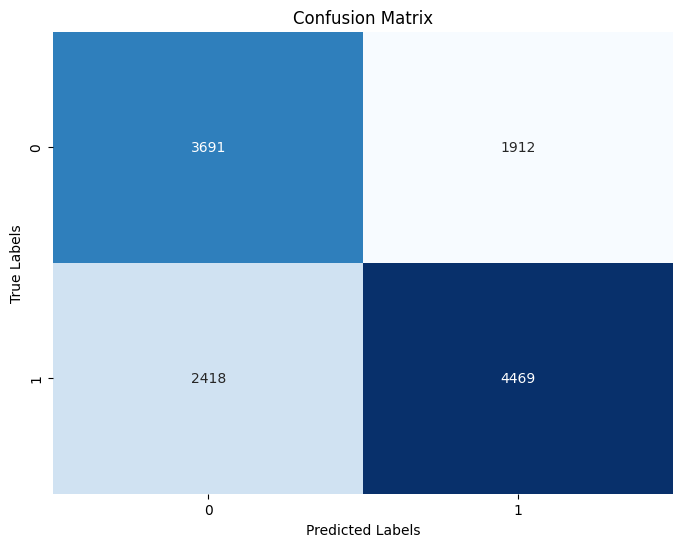

Accuracy: 0.65
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.66      0.63      5603
           1       0.70      0.65      0.67      6887

    accuracy                           0.65     12490
   macro avg       0.65      0.65      0.65     12490
weighted avg       0.66      0.65      0.65     12490



In [ ]:
# Obtain predictions from pre-trained models
svc_pred = svc_ST.predict(X_test)
tree_pred = tree_ST.predict(X_test)
log_pred = log_ST.predict(X_test)
forest_pred = forest_ST.predict(X_test)

combined_pred, _ = mode([svc_pred, tree_pred, log_pred, forest_pred], axis=0)
combined_pred = combined_pred.ravel()

# Evaluate combined predictions
accuracy = accuracy_score(y_test, combined_pred)
classification_report_str = classification_report(y_test, combined_pred)
conf_matrix = confusion_matrix(y_test, combined_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report_str)

In [ ]:
def ensemble(X_train, X_test, y_train, y_test, svc, tree, log, forest):
  # Obtain predictions from pre-trained models
  svc_pred = svc.predict(X_test)
  tree_pred = tree.predict(X_test)
  log_pred = log.predict(X_test)
  forest_pred = forest.predict(X_test)
  combined_pred, _ = mode([svc_pred, tree_pred, log_pred, forest_pred], axis=0)
  combined_pred = combined_pred.ravel()
  # Evaluate combined predictions
  accuracy = accuracy_score(y_test, combined_pred)
  classification_report_str = classification_report(y_test, combined_pred)
  conf_matrix = confusion_matrix(y_test, combined_pred)
  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.show()
  # Print evaluation metrics
  print(f"Accuracy: {accuracy:.2f}")
  print("Classification Report:\n", classification_report_str)

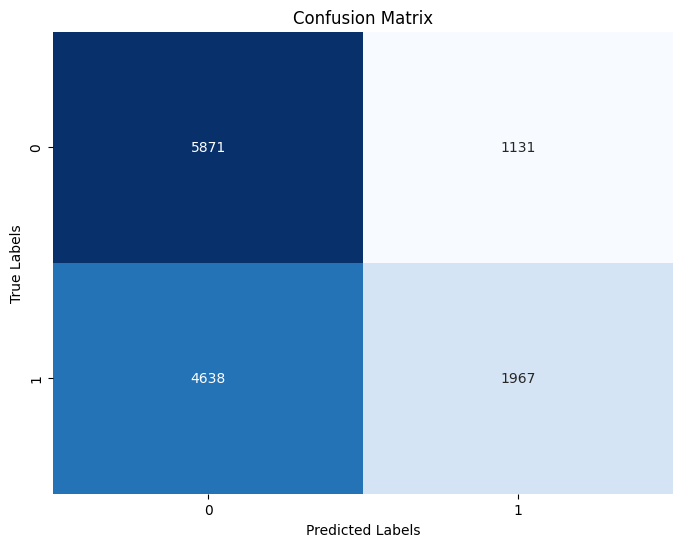

Accuracy: 0.58
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.84      0.67      7002
           1       0.63      0.30      0.41      6605

    accuracy                           0.58     13607
   macro avg       0.60      0.57      0.54     13607
weighted avg       0.60      0.58      0.54     13607



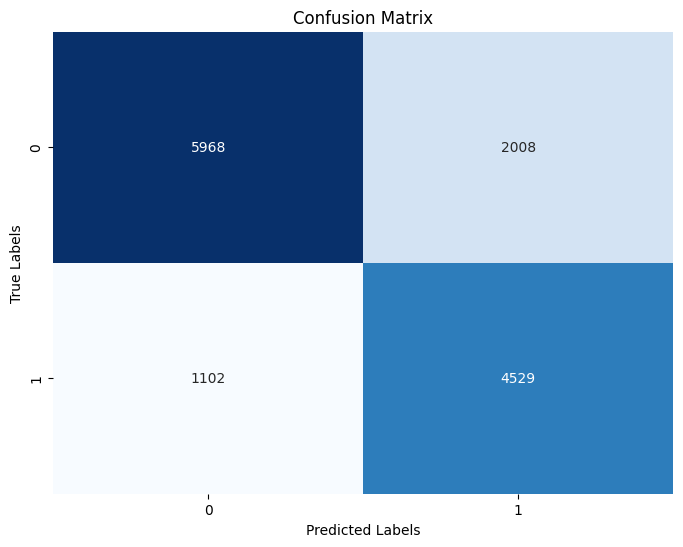

Accuracy: 0.77
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.75      0.79      7976
           1       0.69      0.80      0.74      5631

    accuracy                           0.77     13607
   macro avg       0.77      0.78      0.77     13607
weighted avg       0.78      0.77      0.77     13607



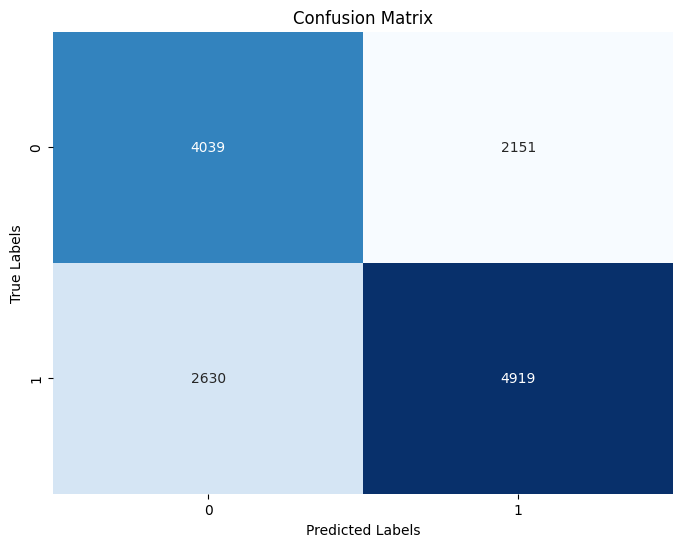

Accuracy: 0.65
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.65      0.63      6190
           1       0.70      0.65      0.67      7549

    accuracy                           0.65     13739
   macro avg       0.65      0.65      0.65     13739
weighted avg       0.66      0.65      0.65     13739



In [ ]:
X_train_FR, X_test_FR, y_train_FR, y_test_FR = train_test_split(X_FR, y_FR.values.ravel(), test_size=0.33, random_state=42)
X_train_PC, X_test_PC, y_train_PC, y_test_PC = train_test_split(X_PC, y_PC.values.ravel(), test_size=0.33, random_state=42)
X_train_ST, X_test_ST, y_train_ST, y_test_ST = train_test_split(X_ST, y_ST.values.ravel(), test_size=0.33, random_state=42)

ensemble(X_train_FR, X_test_FR, y_train_FR, y_test_FR, svc_FR, tree_FR, log_FR, forest_FR)
ensemble(X_train_PC, X_test_PC, y_train_PC, y_test_PC, svc_PC, tree_PC, log_PC, forest_PC)
ensemble(X_train_ST, X_test_ST, y_train_ST, y_test_ST, svc_ST, tree_ST, log_ST, forest_ST)

In [ ]:
def ensemble_predict(new_unit, svc, tree, log, forest):
  # Obtain predictions from pre-trained models
  svc_pred = svc.predict(new_unit)
  tree_pred = tree.predict(new_unit)
  log_pred = log.predict(new_unit)
  forest_pred = forest.predict(new_unit)
  combined_pred, _ = mode([svc_pred, tree_pred, log_pred, forest_pred], axis=0)
  combined_pred = combined_pred.ravel()
  return combined_pred

In [ ]:
# new user arrives
new_user = [0,0,1] #persona number 001
corresponding_persona = new_user[0]*4 + new_user[1] + new_user[2]*2


new_user = pd.DataFrame(np.array([corresponding_persona,0,0,1]).reshape(1, -1))
new_user.columns = ['persona', 'age', 'gender', 'education']

prediction_FR = ensemble_predict(new_user, svc_FR, tree_FR, log_FR, forest_FR)
prediction_PC = ensemble_predict(new_user, svc_PC, tree_PC, log_PC, forest_PC)
prediction_ST = ensemble_predict(new_user, svc_ST, tree_ST, log_ST, forest_ST)
response = [corresponding_persona, prediction_FR[0], prediction_PC[0], prediction_ST[0]]

# When a new user arrives
tactics = ['Framing', 'Peer Comparison', 'Storytelling']

print(f'New user has been classified to persona {response[0]}')
print(f'Value for Framing: {response[1]}')
print(f'Value for Peer Comparison: {response[2]}')
print(f'Value for Storytelling: {response[3]}')

suggested_tactic_index = np.where(response == np.max(response[1:4]))[0]

for i in suggested_tactic_index:
  sugg_tac = tactics[i-1]
  print('Suggested tactic is: ' + sugg_tac)

New user has been classified to persona 2
Value for Framing: 1
Value for Peer Comparison: 0
Value for Storytelling: 1
Suggested tactic is: Framing
Suggested tactic is: Storytelling


## Multi Armed Bandit (understand better)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

I recoded the Bernoulli Bandit class to be able to sample from a labeled dataset. In our case this labeled dataset will be, for example, y_ST for persona 1.

In [35]:
class BernoulliBandit:
    def __init__(self, dataset):
        self.dataset = dataset
        self.index = 0

    def pull(self):
        # Get response from the dataset
        response = self.dataset[self.index]

        # Move to the next data point for the next pull
        self.index += 1
        if self.index >= len(self.dataset):
            self.index = 0  # Reset index if reached the end of the dataset

        return response

In [36]:
np.random.seed(33)


class BayesianBandit:
    def __init__(self, arm_count):
        self.alpha = np.ones(arm_count)
        self.beta = np.ones(arm_count)
        self.history = np.zeros((arm_count, 0))

    def update(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward
        self.history = np.hstack((self.history, self.alpha / (self.alpha + self.beta)[:, None]))

    def sample(self):
        return np.random.beta(self.alpha, self.beta)


def simulate(bandits, bandit_algo, n_trials):
    arm_count = len(bandits)
    rewards = np.zeros(n_trials)

    for t in range(n_trials):
        arm_to_pull = np.argmax(bandit_algo.sample())
        #print(arm_to_pull)
        reward = bandits[arm_to_pull].pull()
        bandit_algo.update(arm_to_pull, reward)
        rewards[t] = reward

    return rewards

def plot_beliefs_history(bandit_algo):
    for i in range(bandit_algo.history.shape[0]):
        plt.plot(bandit_algo.history[i], label=f"Arm {i+1}")

    plt.title("History of Beliefs about p-values of Each Arm")
    plt.xlabel("Trial")
    plt.ylabel("Estimated p-value")
    plt.legend()
    plt.show()

    return bandit_algo.history[-1]

def plot_beliefs(bandit_algo, true_p_values):
    x = np.linspace(0, 1, 200)
    arm_count = len(bandit_algo.alpha)

    for i in range(arm_count):
        y = beta.pdf(x, bandit_algo.alpha[i], bandit_algo.beta[i])
        plt.plot(x, y, label=f"Arm {i + 1} - True p: {true_p_values[i]:.2f}")

    plt.title("Beliefs about p-values of each arm")
    plt.xlabel("p-value")
    plt.ylabel("Probability density")
    plt.legend()
    plt.show()

In [37]:
# Generating random probabilities for the 3 Bernoulli Bandits
y__FR = np.array(y_FR[X_FR['persona']==1]).reshape(-1)
y__PC = np.array(y_PC[X_PC['persona']==1]).reshape(-1)
y__ST = np.array(y_ST[X_ST['persona']==1]).reshape(-1)

ys = [y__FR, y__PC, y__ST]

bandits = [BernoulliBandit(y) for y in ys]

# Running the Bayesian Bandit algorithm for 10000 trials
bandit_algo = BayesianBandit(len(bandits))
n_trials = 20000
rewards = simulate(bandits, bandit_algo, n_trials)

print(f"Total reward: {rewards.sum()}")
print(f"Average reward per trial: {rewards.sum() / n_trials}")

Total reward: 12858.0
Average reward per trial: 0.6429


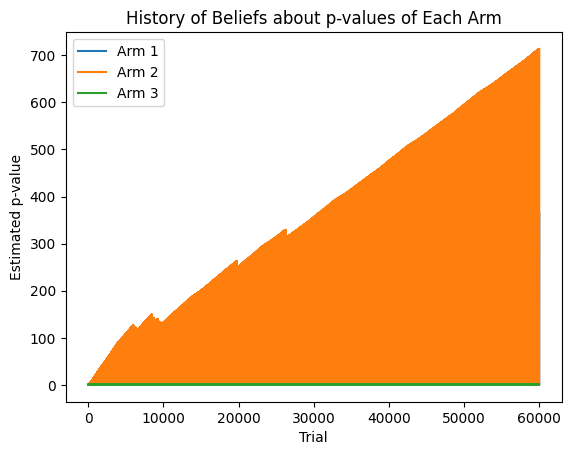

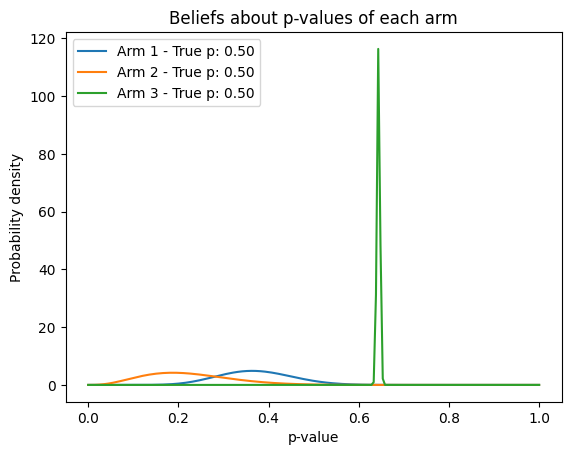

In [38]:
# Plotting the history of beliefs about p-values of each arm
last_ps = plot_beliefs_history(bandit_algo)

# Plotting the beliefs about p-values of each arm
plot_beliefs(bandit_algo, last_ps)

In [39]:
# Generating new observations
n_new_trials = 5
new_rewards = np.zeros(n_new_trials)
new_observations = [bandit.pull() for bandit in bandits]

# Making a prediction based on the new observations
for t, observation in enumerate(new_observations):
    arm_to_pull = np.argmax(bandit_algo.sample())
    bandit_algo.update(arm_to_pull, observation)
    new_rewards[t] = observation

print(f"New rewards: {new_rewards}")
print(f"Total reward after new observations: {new_rewards.sum() + rewards.sum()}")

New rewards: [0. 1. 1. 0. 0.]
Total reward after new observations: 12860.0
